In [ ]:
from google.colab import drive
import os

# Google Drive 마운트
drive.mount('/content/drive')

# 작업 디렉토리 설정
os.chdir('/content/drive/MyDrive/swe캡스톤/model')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import re

def parse_coordinates(file_path):
  coordinates = []
  with open(file_path, 'r') as file:
    lines = file.readlines()
    for i in range(0, len(lines), 6):
      slot_id = int(lines[i].strip())
      bottom_left = re.findall(r"\d+\.\d+", lines[i + 1])
      bottom_right = re.findall(r"\d+\.\d+", lines[i + 2])
      top_left = re.findall(r"\d+\.\d+", lines[i + 3])
      top_right = re.findall(r"\d+\.\d+", lines[i + 4])

      bottom_left = (float(bottom_left[0]), float(bottom_left[1]))
      bottom_right = (float(bottom_right[0]), float(bottom_right[1]))
      top_left = (float(top_left[0]), float(top_left[1]))
      top_right = (float(top_right[0]), float(top_right[1]))

      coordinates.append((bottom_left, bottom_right, top_left, top_right))
  return coordinates

In [ ]:
import cv2
import numpy as np

def crop_area(image, pts):
  pts = np.array(pts, dtype=np.float32)

  # 변환 후 크기
  width = int(np.linalg.norm(pts[1] - pts[0]))
  height = int(np.linalg.norm(pts[3] - pts[0]))
  dst_points = np.array([
      [0, 0],               # 왼쪽 위
      [width, 0],           # 오른쪽 위
      [width, height],      # 오른쪽 아래
      [0, height]           # 왼쪽 아래
        ], dtype=np.float32)

  # 원근 변환 행렬 계산
  transform_matrix = cv2.getPerspectiveTransform(pts, dst_points)
  cropped = cv2.warpPerspective(image, transform_matrix, (width, height))
  return cropped

In [ ]:
def is_empty_parking_spot(area):
  hsv = cv2.cvtColor(area, cv2.COLOR_BGR2HSV)

  # 회색 범위 설정 (Hue: 110~170, Saturation: 0~35, Brightness: 80~160)
  lower_gray = np.array([110, 0, 0])
  upper_gray = np.array([170, 35, 180])

  # 회색 마스크 생성
  mask = cv2.inRange(hsv, lower_gray, upper_gray)
  gray_ratio = np.sum(mask > 0) / (area.shape[0] * area.shape[1])  # 회색 비율 계산

  # 비율 기준으로 빈 자리 여부 판별
  return gray_ratio > 0.35

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def process_parking_lot(image_path, coordinates):
  image = cv2.imread(image_path)
  return_image = cv2.imread(image_path)
  parking_status = []

  idx = 0
  for bottom_left, bottom_right, top_left, top_right in coordinates:
    idx += 1
    pts = np.array([[bottom_left[0], bottom_left[1]], [bottom_right[0], bottom_right[1]], [top_right[0], top_right[1]], [top_left[0], top_left[1]]])
    area = crop_area(image, pts)

    # 빈 자리 판별
    empty = is_empty_parking_spot(area)
    status = "Empty" if empty else "Occupied"
    parking_status.append((idx, status))

    # 결과 표시
    color = (0, 255, 0) if empty else (0, 0, 255)
    cv2.polylines(return_image, np.int32([pts]), True, color, 2)
    cv2.putText(return_image, status, (int(top_left[0]), int(top_left[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  cv2.imwrite('./output.jpg', return_image)
  plt.figure(figsize=(10, 10))
  plt.imshow(cv2.cvtColor(return_image, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  #plt.show()

  return parking_status

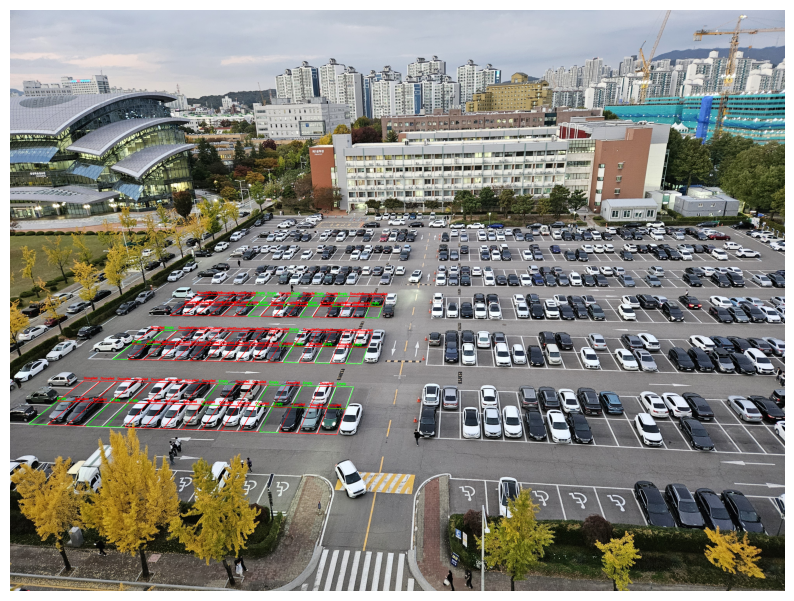

In [ ]:
image_path = './data/4.jpg'
coordinate_file = './data/카메라4 좌표.txt'
coordinates = parse_coordinates(coordinate_file)

# 빈자리 분석 실행
status = process_parking_lot(image_path, coordinates)

# # 결과 출력
# for spot in status:
#     print(f"Parking Spot {spot[0]} -> {spot[1]}")

In [ ]:
plt.close('all')

In [ ]:
import torch

image_path = './data/1.jpg'

model_path = './yolov5/runs/train/car_detection_results2/weights/best.pt'  # 학습된 모델 경로
model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path)

result = model(image_path)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-11-18 Python-3.10.12 torch-2.5.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


In [ ]:
results = result.pandas().xyxy[0]
print(results)

            xmin         ymin         xmax         ymax  confidence  class  \
0    2361.233643  1530.396729  2455.579590  1634.817871    0.827514      0   
1    1864.550659  1210.054199  1919.406372  1347.488892    0.815609      0   
2     984.149353  1558.906250  1083.012939  1681.552979    0.814520      0   
3    2571.036865  1532.362305  2677.157227  1637.678711    0.807689      0   
4    1905.590088  1534.284790  1990.518555  1702.919189    0.806034      0   
..           ...          ...          ...          ...         ...    ...   
210  1379.464600  1494.024536  1453.376587  1614.054321    0.256526      0   
211  2282.767578  1560.148926  2363.738770  1684.046265    0.254382      0   
212   457.578094  1539.120972   575.284180  1627.173706    0.253563      0   
213  1901.258545   971.477722  1965.625000  1031.434448    0.252661      0   
214   691.410583  1408.725342   786.799866  1491.886841    0.250051      0   

    name  
0    car  
1    car  
2    car  
3    car  
4    car

In [ ]:
def convert_coordinates(coordinates, img_width, img_height):
    converted = []
    for bottom_left, bottom_right, top_left, top_right in coordinates:
        bottom_left = (bottom_left[0] / img_width, bottom_left[1] / img_height)
        bottom_right = (bottom_right[0] / img_width, bottom_right[1] / img_height)
        top_left = (top_left[0] / img_width, top_left[1] / img_height)
        top_right = (top_right[0] / img_width, top_right[1] / img_height)
        converted.append((bottom_left, bottom_right, top_left, top_right))
    return converted

def load_detections(detection_file):
    detections = []
    with open(detection_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.strip().split()
            slot_class = np.int32(parts[0])
            center_x = np.float32(parts[1])
            center_y = np.float32(parts[2])
            detections.append((slot_class, center_x, center_y))
    return detections

In [ ]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

def check_parking_status(coordinates, car_detections, image_path, labels):
    img = cv2.imread(image_path)

    for bottom_left, bottom_right, top_left, top_right in coordinates:
        bottom_left = (bottom_left[0] * img.shape[1], bottom_left[1] * img.shape[0])
        bottom_right = (bottom_right[0] * img.shape[1], bottom_right[1] * img.shape[0])
        top_left = (top_left[0] * img.shape[1], top_left[1] * img.shape[0])
        top_right = (top_right[0] * img.shape[1], top_right[1] * img.shape[0])
        poly_list = [bottom_left, bottom_right, top_right, top_left]
        polygon = Polygon(poly_list)

        is_occupied = False

        center_x = (car_detections['xmax'] + car_detections['xmin']) / 2
        center_y = (car_detections['ymax'] + car_detections['ymin']) / 2

        for i in range(len(center_x)):
            if polygon.contains(Point(center_x[i], center_y[i])):
                is_occupied = True
                break

        color = (0, 255, 0) if not is_occupied else (0, 0, 255)
        status_text = "Empty" if not is_occupied else "Occupied"

        pts = np.array([[bottom_left[0], bottom_left[1]], [bottom_right[0], bottom_right[1]], [top_right[0], top_right[1]], [top_left[0], top_left[1]]])
        cv2.polylines(img, np.int32([pts]), True, color, 2)
        cv2.putText(img, status_text, (int(top_left[0]), int(top_left[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        if is_occupied:
            labels.append((is_occupied, float(car_detections['confidence'][i])))
        else:
            labels.append((is_occupied, 1.0))

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

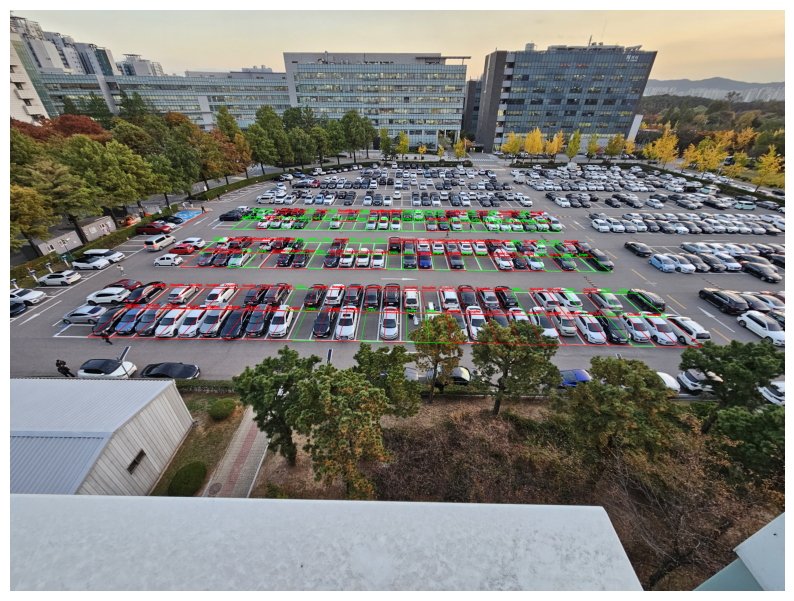

[(True, 0.6633014678955078), (True, 0.5571330785751343), (True, 0.7322597503662109), (True, 0.7940601110458374), (True, 0.8145201802253723), (True, 0.6893642544746399), (True, 0.7076353430747986), (True, 0.6684970855712891), (True, 0.6381620764732361), (False, 1.0), (True, 0.5591031312942505), (True, 0.7619466781616211), (False, 1.0), (True, 0.806033730506897), (False, 1.0), (False, 1.0), (True, 0.2577337920665741), (True, 0.8275144696235657), (True, 0.6181496381759644), (True, 0.8076891899108887), (True, 0.6699132919311523), (True, 0.7450193762779236), (True, 0.7188747525215149), (True, 0.6948885917663574), (False, 1.0), (True, 0.6706392765045166), (True, 0.550184428691864), (True, 0.2500513195991516), (True, 0.31856799125671387), (True, 0.6533126831054688), (True, 0.6227256059646606), (True, 0.5959989428520203), (True, 0.7590408325195312), (True, 0.6628373861312866), (True, 0.678016722202301), (False, 1.0), (True, 0.7167001366615295), (True, 0.7142481207847595), (True, 0.751905977725

In [ ]:
labels = []
coordinates = parse_coordinates('./data/카메라1 좌표.txt')
coordinates = convert_coordinates(coordinates, 4000, 3000)
car_detections = results
image_path = './data/1.jpg'

check_parking_status(coordinates, car_detections, image_path, labels)

print(labels)

In [ ]:
color_anlysis = []

for idx, status in status:
  if status == 'Occupied':
    color_anlysis.append(True)
  else:
    color_anlysis.append(False)

print(color_anlysis)

[True, True, True, True, True, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, False, True, False, True, True, False, True, True, True, True, True, True, False, True, True, True, True, False, True, True, False, True, False, True, False, True, True, True, False, False, True, True, False, True, True, True, True, False, True, True, False, True, False, False, True, True, True, False, True, False, True, False, True, True, False, True, True, True, False, False, True, False, False, False, True, True, True, True, True, True, True, True, True, True, True, False, True, True, False, False, True, True, True, True, False, False, True, False, False, True, True, True, False, False, True, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True, False, True, False, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True

In [ ]:
cmp = []

for i in range(len(labels)):
  cmp.append((labels[i][0] != color_anlysis[i], labels[i][1]))
cmp

[(False, 0.6633014678955078),
 (False, 0.5571330785751343),
 (False, 0.7322597503662109),
 (False, 0.7940601110458374),
 (False, 0.8145201802253723),
 (False, 0.6893642544746399),
 (False, 0.7076353430747986),
 (False, 0.6684970855712891),
 (False, 0.6381620764732361),
 (False, 1.0),
 (False, 0.5591031312942505),
 (False, 0.7619466781616211),
 (False, 1.0),
 (False, 0.806033730506897),
 (True, 1.0),
 (True, 1.0),
 (False, 0.2577337920665741),
 (False, 0.8275144696235657),
 (False, 0.6181496381759644),
 (False, 0.8076891899108887),
 (False, 0.6699132919311523),
 (False, 0.7450193762779236),
 (False, 0.7188747525215149),
 (False, 0.6948885917663574),
 (True, 1.0),
 (False, 0.6706392765045166),
 (False, 0.550184428691864),
 (False, 0.2500513195991516),
 (True, 0.31856799125671387),
 (False, 0.6533126831054688),
 (True, 0.6227256059646606),
 (False, 0.5959989428520203),
 (True, 0.7590408325195312),
 (False, 0.6628373861312866),
 (False, 0.678016722202301),
 (False, 1.0),
 (False, 0.7167001

In [ ]:
r = []

for idx, (status, confidence) in enumerate(cmp):
  if status and confidence > 0.7 and confidence != 1.0:
    r.append((idx + 1, confidence))
r

[(33, 0.7590408325195312)]

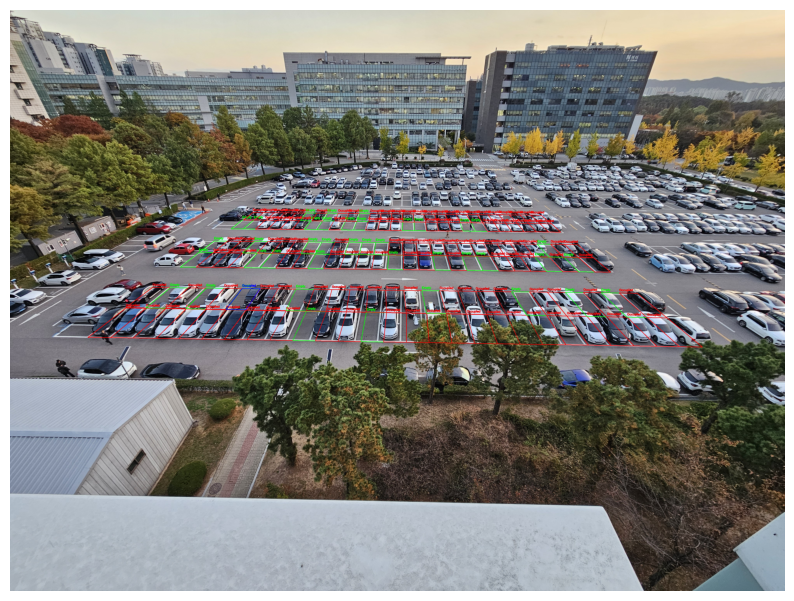

In [ ]:
idx = 0
coordinate_file = './data/카메라1 좌표.txt'
coordinates = parse_coordinates(coordinate_file)
return_image = cv2.imread('./output.jpg')

for bottom_left, bottom_right, top_left, top_right in coordinates:
  idx += 1
  pts = np.array([[bottom_left[0], bottom_left[1]], [bottom_right[0], bottom_right[1]], [top_right[0], top_right[1]], [top_left[0], top_left[1]]])

  for i in r:
    if (idx == i[0]):
      color = (255, 0, 0)
      cv2.polylines(return_image, np.int32([pts]), True, color, 2)
      cv2.putText(return_image, 'Occupied', (int(top_left[0]), int(top_left[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(return_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()